In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))

In [2]:
import numpy as np 
import torch
import torchvision
import matplotlib.pyplot as plt
import datasets.mnist as mnist
import datasets.cifar10 as cifar10
import constants
from configuration import Configuration
from util import *

In [3]:
# on the cblgpu01 or 06 computer
checkpoints_methods = [
    #('run-20210520_201621-1tac73ie', 'Ens 3'), ('run-20210520_232903-3edza10c', 'MCDrop 3, rate 0.1'), 
    #('run-20210520_215226-2829ms12', 'NCEns 3 anneal'), ('run-20210520_183333-q4byxnks', 'NCEns 3 w2'), 
    ('run-20210521_002758-6tow019f', 'Single'), 
    ('run-20210521_133234-2zgcfz21', 'Ens 5'),
    #('run-20210521_135148-2174fa8f', 'NCEns 5 anneal'), 
    # ('run-20210521_135356-1z9btw0n', 'NCEns 5 w2'),
    # ('run-20210521_135447-18fwsxyd', 'MCDrop 5, rate 0.1')
    ('run-20210606_220130-3k51e8yb', 'CEEns 5 w0.8'),
    # ('run-20210607_053840-2ix1adts', 'CEEns 5 w0.9')
    ]

checkpoints_annealing = [
    #('run-20210523_202732-2o5htajn', 'NCEns-5 w10 decay0.985'),
    #('run-20210524_054053-k9s2cx2i', 'NCEns-5 w5'),
    # ('run-20210523_224635-2m4ul8lw', 'NCEns-5 w10 decay0.98'),
    ('run-20210524_010345-9gt6gv8b', 'NCEns-5 w100 decay0.93'),
    #('run-20210524_032114-b14iu9ek', 'NCEns-5 w100 decay0.9')
]

In [4]:
checkpoints = checkpoints_methods + checkpoints_annealing

In [5]:
device='cuda'
checkpoint_epoch = 180


In [5]:
# for CIFAR, shifted ID data
corruption_intensity = 4
thresholds = np.linspace(0, 1, 50)
entropy_bins = np.linspace(-1, 2.5, 100)

res = []

for run_id, name in checkpoints:

    trainer, model_args = load_trainer(run_id, checkpoint_epoch, device)

    test_loader = cifar10.get_test_loader(model_args.data_dir, model_args.batch_size, corrupted=True, 
                                            corruptions=constants.CORRUPTIONS, intensities=[corruption_intensity], 
                                            is_cifar10=model_args.dataset_type=='cifar10')


    metric_dict = {'NLL': lambda p, g: metrics.basic_cross_entropy(p, g).item(), 
                    'ECE': metrics.wrap_ece(bins=20), 
                    'Brier': metrics.wrap_brier()}

    # acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies, _, _ = trainer.test(test_loader=test_loader, metric_dict=metric_dict, confidence_thresholds=thresholds, entropy_bins=entropy_bins)
    acc, metric_res, stat_tracker = trainer.test(test_loader=test_loader, metric_dict=metric_dict, confidence_thresholds=thresholds, entropy_bins=entropy_bins)
    thresholded_accuracies, thresholded_counts = stat_tracker.get_counts_acc_by_confidence()
    binned_entropies = stat_tracker.get_binned_entropies()
    

    res.append((name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies))

SGD optimizer
using multistep scheduler
  0%|          | 0/1485 [00:00<?, ?batch/s]
Testing
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1485/1485 [00:14<00:00, 99.53batch/s]
Results: 
Accuracy: 0.6187684210526316
NLL: 2.391129793448197
ECE: 0.28229436558586984
Brier: 0.6290117104680915
Initialising an ensemble of 5 networks
SGD optimizer
  0%|          | 0/1485 [00:00<?, ?batch/s]
Testing
  0%|          | 5/1485 [00:00<01:19, 18.56batch/s]/homes/gp491/deepens/metrics.py:230: UserWa

In [6]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Count vs Confidence. Corrupted, intensity 4')

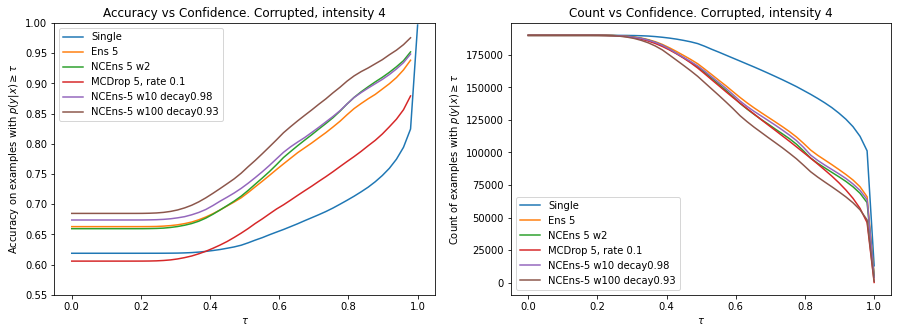

In [7]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
for name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies in res:
    plt.plot(thresholds, thresholded_accuracies, label=name)
# plt.plot(thresholds, thresholds, '--')
plt.ylim(0.55, 1)
plt.xlabel(r'$\tau$')
plt.ylabel(r'Accuracy on examples with $p(y|x) \geq \tau$')
plt.legend()
plt.title(f'Accuracy vs Confidence. Corrupted, intensity {corruption_intensity}')

plt.subplot(122)
for name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies in res:
    plt.plot(thresholds, thresholded_counts, label=name)
plt.xlabel(r'$\tau$')
plt.ylabel(r'Count of examples with $p(y|x) \geq \tau$')
plt.legend()
plt.title(f'Count vs Confidence. Corrupted, intensity {corruption_intensity}')

Single
78220.0
Ens 5
50334.0
NCEns 5 w2
47008.0
MCDrop 5, rate 0.1
25881.0
NCEns-5 w10 decay0.98
49137.0
NCEns-5 w100 decay0.93
32844.0


Text(0.5, 1.0, 'Count vs Entropy. Corrupted, intensity 4')

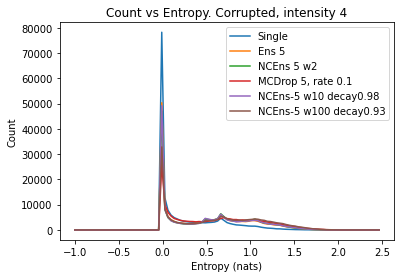

In [8]:
for name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies in res:
    plt.plot(entropy_bins[:-1], binned_entropies, label=name)
    print(name)
    print(max(binned_entropies))
plt.xlabel(r'Entropy (nats)')
plt.ylabel(r'Count')
plt.legend()
plt.title(f'Count vs Entropy. Corrupted, intensity {corruption_intensity}')

## OOD Data

In [10]:
# for CIFAR
thresholds = np.linspace(0, 1, 50)
entropy_bins = np.linspace(-1, 2.5, 100) # since only entropy really makes sense

res_ood = []

for run_id, name in checkpoints:

    trainer, model_args = load_trainer(run_id, checkpoint_epoch, device)

    # only for models trained on CIFAR10
    test_set = torchvision.datasets.SVHN(root=constants.DATA_DIR, split='train', download=True, transform=torchvision.transforms.ToTensor())
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=128)


    metric_dict = {'NLL': lambda p, g: metrics.basic_cross_entropy(p, g).item(), 
                    'ECE': metrics.wrap_ece(bins=20), 
                    'Brier': metrics.wrap_brier()}

    # acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies, _, _ = trainer.test(test_loader=test_loader, metric_dict=metric_dict, confidence_thresholds=thresholds, entropy_bins=entropy_bins)
    acc, metric_res, stat_tracker = trainer.test(test_loader=test_loader, metric_dict=metric_dict, confidence_thresholds=thresholds, entropy_bins=entropy_bins)

    thresholded_accuracies, thresholded_counts = stat_tracker.get_counts_acc_by_confidence()
    binned_entropies = stat_tracker.get_binned_entropies()

    res_ood.append((name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies))

SGD optimizer
using multistep scheduler
Using downloaded and verified file: /scratch/gp491/data/train_32x32.mat
  0%|          | 0/573 [00:00<?, ?batch/s]/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/metrics.py:230: UserWarning: Warning: converting a masked element to nan.
  accuracies[i] = np.ma.masked_array(eq, mask=~mask).mean(-1)
  1%|          | 5/573 [00:00<00:12, 45.60batch/s]
Testing
100%|██████████| 573/573 [00:10<00:00, 54.50batch/s]
Results: 
Accuracy: 0.12342847782464

Single
6103.0
Ens 5
4060.0
NCEns 5 w2
7061.0
MCDrop 5, rate 0.1
3124.0
NCEns-5 w10 decay0.98
11743.0
NCEns-5 w100 decay0.93
3377.0


Text(0.5, 1.0, 'Count vs Entropy. OOD dataset.')

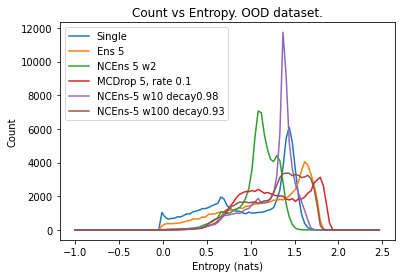

In [11]:
for name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies in res_ood:
    plt.plot(entropy_bins[:-1], binned_entropies, label=name)
    print(name)
    print(max(binned_entropies))
plt.xlabel(r'Entropy (nats)')
plt.ylabel(r'Count')
plt.legend()
plt.title(f'Count vs Entropy. OOD dataset.')

Text(0.5, 1.0, 'Count vs Confidence. OOD Data')

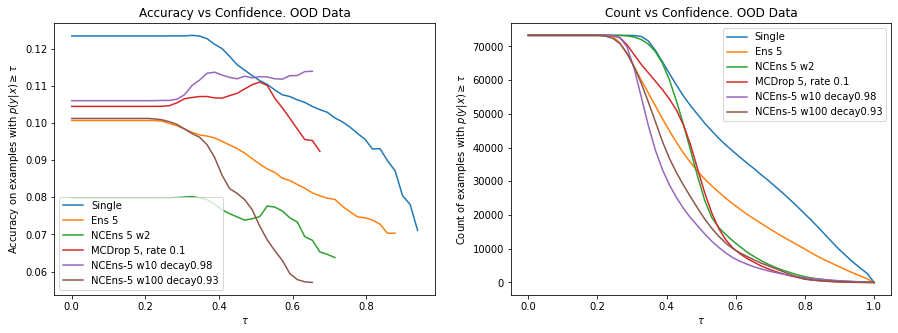

In [12]:
plt.figure(figsize=(15, 5))

plt.subplot(121)

for name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies in res_ood:
    plt.plot(thresholds, thresholded_accuracies, label=name)
plt.xlabel(r'$\tau$')
plt.ylabel(r'Accuracy on examples with $p(y|x) \geq \tau$')
plt.legend()
plt.title(f'Accuracy vs Confidence. OOD Data')

plt.subplot(122)
for name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies in res_ood:
    plt.plot(thresholds, thresholded_counts, label=name)
plt.xlabel(r'$\tau$')
plt.ylabel(r'Count of examples with $p(y|x) \geq \tau$')
plt.legend()
plt.title(f'Count vs Confidence. OOD Data')

In [3]:
# run_id = 'run-20210521_133234-2zgcfz21' # regular ens
run_id = 'run-20210521_135356-1z9btw0n' # nc ens
checkpoint_epoch = 180
device='cuda'

Initialising a negative-correlation normalised ensemble of 5 networks
SGD optimizer


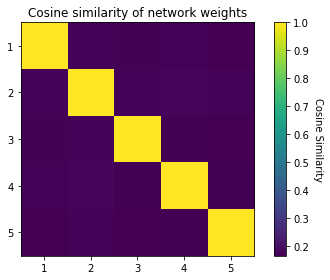

In [4]:
trainer, model_args = load_trainer(run_id, checkpoint_epoch, device)
mat = plot_cosine_similarity(trainer)

In [6]:
test_loader = cifar10.get_test_loader(model_args.data_dir, model_args.batch_size, corrupted=False, corruptions=constants.CORRUPTIONS, intensities=[3])


metric_dict = {'NLL': lambda p, g: metrics.basic_cross_entropy(p, g).item(), 
                'ECE': metrics.wrap_ece(bins=20), 
                'Brier': metrics.wrap_brier()}

# acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies, disagreement_mat, calibration_hist = trainer.test(test_loader=test_loader, metric_dict=metric_dict, track_full_disagreements=True, calibration_hist_bins=15)
acc, metric_res, stat_tracker = trainer.test(test_loader=test_loader, metric_dict=metric_dict, track_full_disagreements=True, calibration_hist_bins=15)
# thresholded_accuracies, thresholded_counts = stat_tracker.get_counts_acc_by_confidence()
# binned_entropies = stat_tracker.get_binned_entropies()
disagreement_mat = stat_tracker.get_disagreement_mat()
calibration_hist = stat_tracker.get_calibration_hist()


  0%|          | 0/79 [00:00<?, ?batch/s]
Testing
100%|██████████| 79/79 [00:02<00:00, 31.35batch/s]Results: 
Accuracy: 0.9319
NLL: 0.21294343315958977
ECE: 0.051348106957972046
Brier: 0.0991389182627201



In [7]:
calibration_hist

(array([0.        , 0.        , 0.        , 0.        , 0.4       ,
        0.33333333, 0.36781609, 0.48947368, 0.57692308, 0.63529412,
        0.71538462, 0.80165289, 0.89378238, 0.92893401, 0.99147066]),
 array([0.        , 0.06666667, 0.13333334, 0.2       , 0.26666668,
        0.33333334, 0.4       , 0.46666667, 0.53333336, 0.6       ,
        0.6666667 , 0.73333335, 0.8       , 0.8666667 , 0.93333334,
        1.        ], dtype=float32))

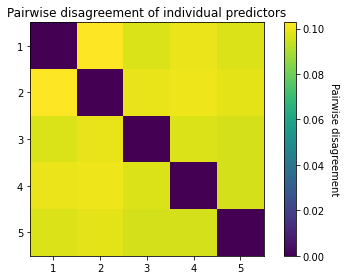

In [8]:
plot_disagreement_mat(disagreement_mat, remove_diag=False)

In [6]:
def run_plotting(run_id, name, corruption):
    has_subnets = not name == 'Single'
    print(name)
    trainer, model_args = load_trainer(run_id, checkpoint_epoch, device)

    print(f'Corruption intensity {corruption}')
    
    test_loader = cifar10.get_test_loader(model_args.data_dir, model_args.batch_size, corrupted=True, 
                                            corruptions=constants.CORRUPTIONS, intensities=[corruption], 
                                            is_cifar10=model_args.dataset_type=='cifar10')


    metric_dict = {'NLL': lambda p, g: metrics.basic_cross_entropy(p, g).item(), 
                'ECE': metrics.wrap_ece(bins=20), 
                'Brier': metrics.wrap_brier()}

    

    # acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies, disagreement_mat, calibration_hist_corr = trainer.test(test_loader=test_loader, metric_dict=metric_dict, track_full_disagreements=has_subnets, calibration_hist_bins=15)
    acc, metric_res, stat_tracker = trainer.test(test_loader=test_loader, metric_dict=metric_dict, track_full_disagreements=has_subnets, calibration_hist_bins=15)
    
    # thresholded_accuracies, thresholded_counts = stat_tracker.get_counts_acc_by_confidence()
    # binned_entropies = stat_tracker.get_binned_entropies()
    calibration_hist_corr = stat_tracker.get_calibration_hist()

    if has_subnets:
        disagreement_mat = stat_tracker.get_disagreement_mat()

        mat = plot_cosine_similarity(trainer, remove_diag=True)
        plot_disagreement_mat(disagreement_mat, remove_diag=False)
    plot_calibration_hist(calibration_hist_corr)

    test_loader = cifar10.get_test_loader(model_args.data_dir, model_args.batch_size, corrupted=False, corruptions=constants.CORRUPTIONS, intensities=[5])
    # acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies, disagreement_mat, calibration_hist = trainer.test(test_loader=test_loader, metric_dict=metric_dict, track_full_disagreements=has_subnets, calibration_hist_bins=15)
    acc, metric_res, stat_tracker = trainer.test(test_loader=test_loader, metric_dict=metric_dict, track_full_disagreements=has_subnets, calibration_hist_bins=15)

    # thresholded_accuracies, thresholded_counts = stat_tracker.get_counts_acc_by_confidence()
    # binned_entropies = stat_tracker.get_binned_entropies()
    calibration_hist = stat_tracker.get_calibration_hist()

    print('Uncorrupted')
    if has_subnets:
        disagreement_mat = stat_tracker.get_disagreement_mat()

        plot_disagreement_mat(disagreement_mat, remove_diag=False)
    plot_calibration_hist(calibration_hist)

    return calibration_hist, calibration_hist_corr

Single
SGD optimizer
using multistep scheduler
Corruption intensity 3


  0%|          | 0/1485 [00:00<?, ?batch/s]


Testing


100%|██████████| 1485/1485 [00:11<00:00, 127.90batch/s]


Results: 
Accuracy: 0.6968315789473685
NLL: 1.7828214569694119
ECE: 0.22542525127514412
Brier: 0.5002524844721744


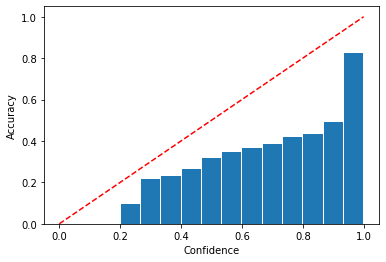

  0%|          | 0/79 [00:00<?, ?batch/s]


Testing


/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 79/79 [00:00<00:00, 105.46batch/s]

Results: 
Accuracy: 0.915
NLL: 0.3810369927316904
ECE: 0.06905074324905873
Brier: 0.13877249516248702
Uncorrupted


NameError: name 'calibration_hist' is not defined

In [12]:
for run_id, name in checkpoints:
    run_plotting(run_id, name, 3)

### Calibration plots
(in "corrupted, og test" data order)

#### Single Net

Single
SGD optimizer
using multistep scheduler
Corruption intensity 3


  0%|          | 0/1485 [00:00<?, ?batch/s]


Testing


100%|██████████| 1485/1485 [00:11<00:00, 127.33batch/s]


Results: 
Accuracy: 0.6968315789473685
NLL: 1.7828214517492997
ECE: 0.22568039674288348
Brier: 0.5002524837945637


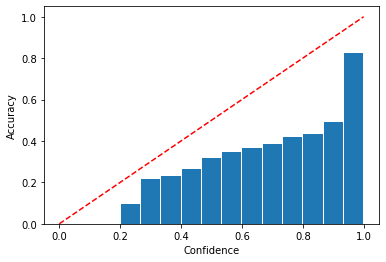

  0%|          | 0/79 [00:00<?, ?batch/s]


Testing


/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 79/79 [00:00<00:00, 105.98batch/s]


Results: 
Accuracy: 0.915
NLL: 0.38103698954582216
ECE: 0.07095372324883938
Brier: 0.13877249393463134
Uncorrupted


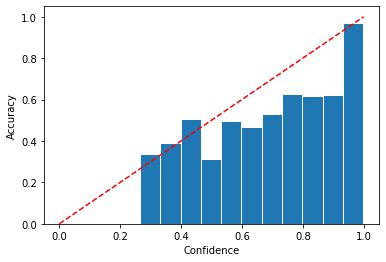

In [14]:
run_id, name = checkpoints[0]
ch, chc = run_plotting(run_id, name, 3)

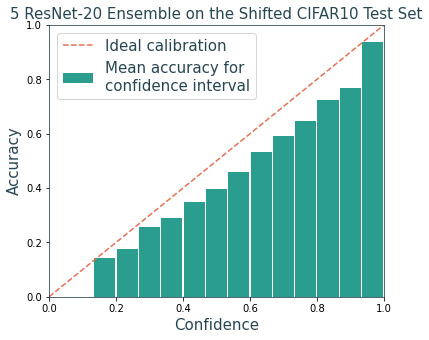

In [13]:
light_green = '#2a9d8f'
orange = '#e76f51'
dark_greeen = '#264653'

values, bins = chce
fig, ax = plt.subplots(figsize=(6,5))

width = bins[1] - bins[0]

ax.bar(bins[:-1] + width/2, values, width*0.95, color=light_green, label='Mean accuracy for\nconfidence interval')
ax.plot(bins, bins, '--', color=orange, label='Ideal calibration')

ax.set_xlabel('Confidence', fontsize=15, color=dark_greeen)
ax.set_ylabel('Accuracy', fontsize=15, color=dark_greeen)
ax.set_title("5 ResNet-20 Ensemble on the Shifted CIFAR10 Test Set", fontsize=15, color=dark_greeen)
ax.set_xlim(0, 1)
ax.set_ylim(0,1)
legend = ax.legend(fontsize=15)

plt.setp(ax.spines.values(), color=dark_greeen)
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=dark_greeen)
plt.setp(legend.get_texts(), color=dark_greeen)

plt.savefig('resnet_ens_cifar_corr_rel_dia.pdf')

plt.show()

#### Simple Deep Ensemble

Ens 5
Initialising an ensemble of 5 networks
SGD optimizer
using multistep scheduler
using multistep scheduler
using multistep scheduler
using multistep scheduler
using multistep scheduler
Corruption intensity 3


  0%|          | 0/1485 [00:00<?, ?batch/s]


Testing


/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1485/1485 [01:13<00:00, 20.23batch/s]


Results: 
Accuracy: 0.7417263157894737
NLL: 1.0370572389452082
ECE: 0.1217147507368734
Brier: 0.37359775025217157


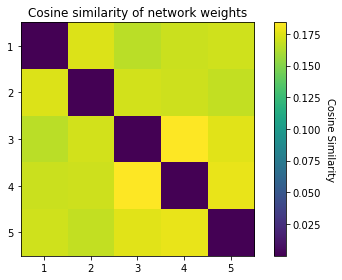

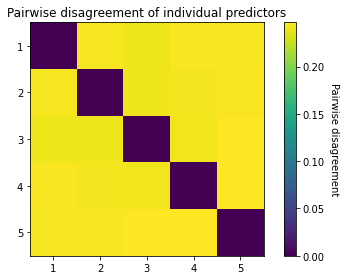

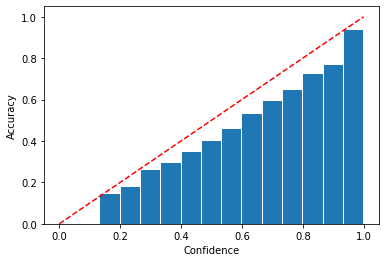

  0%|          | 0/79 [00:00<?, ?batch/s]


Testing


/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 79/79 [00:04<00:00, 19.36batch/s]


Results: 
Accuracy: 0.9363
NLL: 0.20722053134441376
ECE: 0.05103983167409897
Brier: 0.0968614441871643
Uncorrupted


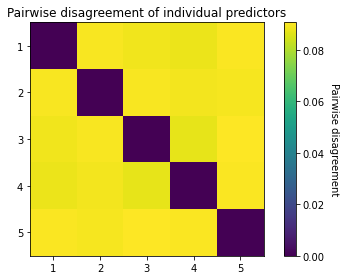

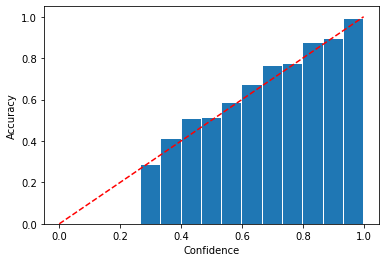

In [7]:
run_id, name = checkpoints[1]
che, chce = run_plotting(run_id, name, 3)

#### Cross-entropy regularised deep ensemble with weight 0.8

CEEns 5 w0.8
Initialising a pairwise cross-entropy regularised ensemble of 5 networks
SGD optimizer
Corruption intensity 3
  0%|          | 0/1485 [00:00<?, ?batch/s]
Testing
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1485/1485 [01:16<00:00, 19.49batch/s]
Results: 
Accuracy: 0.7406894736842106
NLL: 0.8942813937689129
ECE: 0.10402941328710631
Brier: 0.3651522283328207
disagreement: 1.4717617728531842e-06
component accuracy: 3.638808864265927e-06
confidence: 4.1204809954952334e-06


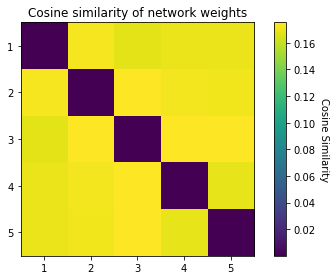

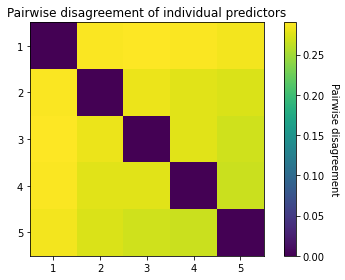

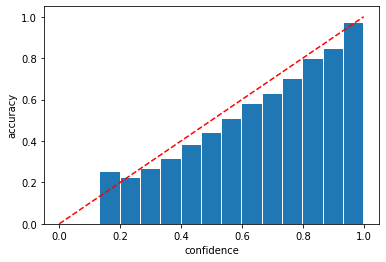

  0%|          | 0/79 [00:00<?, ?batch/s]
Testing
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 79/79 [00:04<00:00, 18.22batch/s]
Results: 
Accuracy: 0.9354
NLL: 0.20531393814086915
ECE: 0.055747380001842976
Brier: 0.09823427608013154
disagreement: 1.0475999999999996e-05
component accuracy: 9.059599999999998e-05
confidence: 9.160983984947204e-05
Uncorrupted


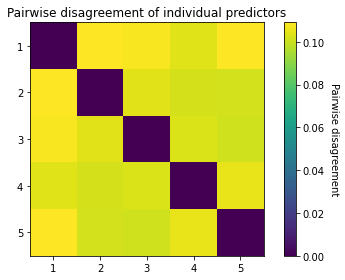

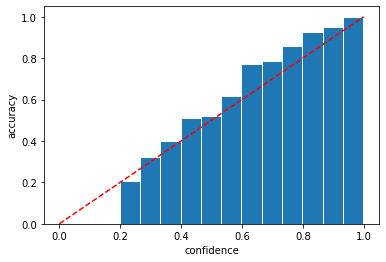

In [12]:
run_id, name = checkpoints[2]
run_plotting(run_id, name, 3)

#### Negative correlation regularised deep ensemble with weight 100, decay 0.93

NCEns-5 w100 decay0.93
Initialising a negative-correlation normalised ensemble of 5 networks
SGD optimizer
Corruption intensity 3
  0%|          | 0/1485 [00:00<?, ?batch/s]
Testing
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1485/1485 [01:14<00:00, 19.86batch/s]
Results: 
Accuracy: 0.7549894736842105
NLL: 0.7983098720399957
ECE: 0.10053798114194681
Brier: 0.34369637181884366
disagreement: 1.5669750692520756e-06
component accuracy: 3.6666648199445967e-06
confidence: 4.1052016656088

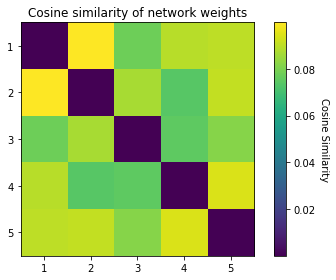

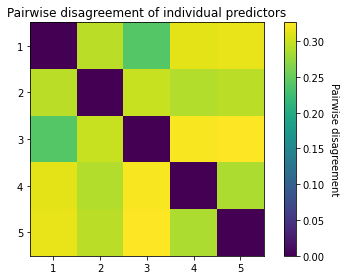

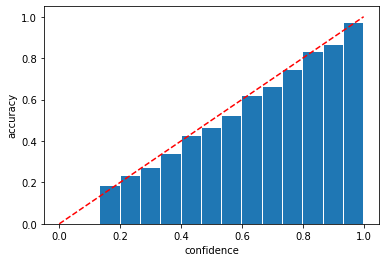

  0%|          | 0/79 [00:00<?, ?batch/s]
Testing
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 79/79 [00:04<00:00, 18.42batch/s]
Results: 
Accuracy: 0.9215
NLL: 0.24614939794540405
ECE: 0.06183146897554397
Brier: 0.11853548533916473
disagreement: 1.2794999999999995e-05
component accuracy: 8.8604e-05
confidence: 9.04154861164093e-05
Uncorrupted


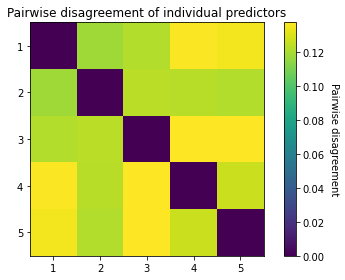

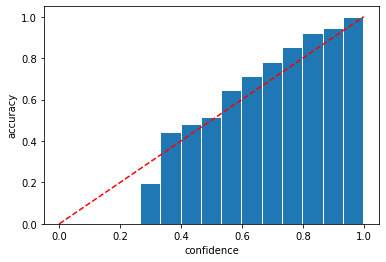

In [13]:
run_id, name = checkpoints[3]
run_plotting(run_id, name, 3)

In [25]:
# a = torch.tensor([0.2, 0.15, 0.15, 0.3, 0.2])
# b = torch.tensor([0.15, 0.17, 0.23, 0.25, 0.2])
# c = torch.tensor([0.22, 0.1, 0.23, 0.25, 0.2])

# a = torch.tensor([0.2, 0.15, 0.15, 0.22, 0.2])
# b = torch.tensor([0.22, 0.17, 0.22, 0.25, 0.2])
# c = torch.tensor([0.1, 0.1, 0.2, 0.21, 0.2])

a = torch.tensor(np.random.rand(5))
b = torch.tensor(np.random.rand(5))
c = torch.tensor(np.random.rand(5))

s = torch.tensor([0.0,0.0,0.0,0.0,0.0])
ss = torch.tensor([0.0,0.0,0.0,0.0,0.0])
for l in [a,b,c]:
    s += l
    ss += torch.nn.functional.softmax(l)

print(torch.nn.functional.softmax(s))
print(torch.nn.functional.softmax(s/3))
print(ss/3)


    

tensor([0.2665, 0.0979, 0.1747, 0.3164, 0.1446])
tensor([0.2242, 0.1606, 0.1948, 0.2375, 0.1829])
tensor([0.2260, 0.1652, 0.1937, 0.2327, 0.1825])
<ipython-input-25-6c2f6ef10762>:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ss += torch.nn.functional.softmax(l)
<ipython-input-25-6c2f6ef10762>:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(torch.nn.functional.softmax(s))
<ipython-input-25-6c2f6ef10762>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(torch.nn.functional.softmax(s/3))
